# Capstone Project: English Premier League Predictions



# Part 4A - Preprocessing, Modeling & Evaluation for Home Total Goals

In this notebook, we will be training the model for our target variable, Home Total Goals.  Similarly to Result, we will be using the dataset which we have combined in the notebook Part 2.

The models used to train will be as followed in the contents. We will grid search for the best parameters for each models then use it with the models.

### Contents:

- [Preparing Dataset for Prediction of Home Total Goals](#Preparing-Dataset-for-Prediction-of-Home-Total-Goals)
    - [Home Total Goals Classes](#Home-Total-Goals-Classes)
    - [Removing Features that will be Irrelevant](#Removing-Features-that-will-be-Irrelevant)
    
- [Building the Model](#Building-the-Modeling)
    - [Train Test Split for Home Total Goals](#Train-Test-Split-for-Home-Total-Goals)
    - [Logistic Regression](#Logistic-Regression)
    - [Random Forest Classification](#Random-Forest-Classification)
    - [ExtraTrees Classifier](#ExtraTrees-Classifier)
    - [AdaBoost Classifier](#AdaBoost-Classifier)
    - [Gradient Boost Classifier](#Gradient-Boost-Classifier)
    - [Support Vector Classifier](#Support-Vector-Classifier)
    - [Model Evaluation & Selection](#Model-Evaluation-&-Selection)

## Importing Modules & Dataset

In [1]:
#Importing of modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import functools
import pickle

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier,plot_tree, export_graphviz
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score,confusion_matrix,accuracy_score,recall_score,f1_score,precision_recall_fscore_support,plot_confusion_matrix

from imblearn.over_sampling import SMOTE

import warnings
import graphviz
warnings.filterwarnings("ignore")

pd.set_option('max_columns',None)

In [ ]:
#Reading in of database
train = pd.read_csv('data/clean/combined_final.csv')

## Preparing Dataset for Prediction of Home Total Goals

Firstly, we will prepare the final dataset for prediction of total goals for Home. We will look through null values and remove features such as current matches stats as they will only happen after a match happened.

In [3]:
#We still have 280 features, we will look into remove some
train.shape

(1324, 264)

In [4]:
#Looking for null values
train.isnull().sum()[train.isnull().sum()>0] 

h_last_5_avrg_gls         12
h_last_5_avrg_ast         12
h_last_5_avrg_pk          12
h_last_5_avrg_pkatt       12
h_last_5_avrg_sh          12
                          ..
a_last_3_avrg_pkcon       15
a_last_3_avrg_og          15
a_last_3_avrg_recov       15
a_last_3_avrg_aer_won     15
a_last_3_avrg_aer_lost    15
Length: 144, dtype: int64

In [5]:
train.head(5)

,date,match,home,stadium,attendance,h_gls,h_ast,h_pk,h_pkatt,h_sh,h_sot,h_yellow,h_red,h_touches,h_press,h_tkl,h_int,h_blk,h_xg,h_npxg,h_xa,h_sca,h_gca,h_cmp,h_pass_att,h_pass_prog,h_carries,h_carries_prog,h_dri_succ,h_dri_att,h_yellow2,h_fls,h_fld,h_off,h_crs,h_tklw,h_pkwon,h_pkcon,h_og,h_recov,h_aer_won,h_aer_lost,h_last_5_avrg_gls,h_last_5_avrg_ast,h_last_5_avrg_pk,h_last_5_avrg_pkatt,h_last_5_avrg_sh,h_last_5_avrg_sot,h_last_5_avrg_yellow,h_last_5_avrg_red,h_last_5_touches,h_last_5_avrg_press,h_last_5_avrg_tkl,h_last_5_avrg_int,h_last_5_avrg_blk,h_last_5_avrg_xg,h_last_5_avrg_xa,h_last_5_avrg_sca,h_last_5_avrg_gca,h_last_5_avrg_cmp,h_last_5_avrg_pass_att,h_last_5_avrg_pass_prog,h_last_5_avrg_carries,h_last_5_avrg_carries_prog,h_last_5_avrg_dri_succ,h_last_5_avrg_dri_att,h_last_5_avrg_yellow2,h_last_5_avrg_fls,h_last_5_avrg_fld,h_last_5_avrg_off,h_last_5_avrg_crs,h_last_5_avrg_tklw,h_last_5_avrg_pkwon,h_last_5_avrg_pkcon,h_last_5_avrg_og,h_last_5_avrg_recov,h_last_5_avrg_aer_won,h_last_5_avrg_aer_lost,h_last_3_avrg_gls,h_last_3_avrg_ast,h_last_3_avrg_pk,h_last_3_avrg_pkatt,h_last_3_avrg_sh,h_last_3_avrg_sot,h_last_3_avrg_yellow,h_last_3_avrg_red,h_last_3_touches,h_last_3_avrg_press,h_last_3_avrg_tkl,h_last_3_avrg_int,h_last_3_avrg_blk,h_last_3_avrg_xg,h_last_3_avrg_xa,h_last_3_avrg_sca,h_last_3_avrg_gca,h_last_3_avrg_cmp,h_last_3_avrg_pass_att,h_last_3_avrg_pass_prog,h_last_3_avrg_carries,h_last_3_avrg_carries_prog,h_last_3_avrg_dri_succ,h_last_3_avrg_dri_att,h_last_3_avrg_yellow2,h_last_3_avrg_fls,h_last_3_avrg_fld,h_last_3_avrg_off,h_last_3_avrg_crs,h_last_3_avrg_tklw,h_last_3_avrg_pkwon,h_last_3_avrg_pkcon,h_last_3_avrg_og,h_last_3_avrg_recov,h_last_3_avrg_aer_won,h_last_3_avrg_aer_lost,away,a_gls,a_ast,a_pk,a_pkatt,a_sh,a_sot,a_yellow,a_red,a_touches,a_press,a_tkl,a_int,a_blk,a_xg,a_npxg,a_xa,a_sca,a_gca,a_cmp,a_pass_att,a_pass_prog,a_carries,a_carries_prog,a_dri_succ,a_dri_att,a_yellow2,a_fls,a_fld,a_off,a_crs,a_tklw,a_pwon,a_pkcon,a_og,a_recov,a_aer_won,a_aer_lost,a_last_5_avrg_gls,a_last_5_avrg_ast,a_last_5_avrg_pk,a_last_5_avrg_pkatt,a_last_5_avrg_sh,a_last_5_avrg_sot,a_last_5_avrg_yellow,a_last_5_avrg_red,a_last_5_touches,a_last_5_avrg_press,a_last_5_avrg_tkl,a_last_5_avrg_int,a_last_5_avrg_blk,a_last_5_avrg_xg,a_last_5_avrg_xa,a_last_5_avrg_sca,a_last_5_avrg_gca,a_last_5_avrg_cmp,a_last_5_avrg_pass_att,a_last_5_avrg_pass_prog,a_last_5_avrg_carries,a_last_5_avrg_carries_prog,a_last_5_avrg_dri_succ,a_last_5_avrg_dri_att,a_last_5_avrg_yellow2,a_last_5_avrg_fls,a_last_5_avrg_fld,a_last_5_avrg_off,a_last_5_avrg_crs,a_last_5_avrg_tklw,a_last_5_avrg_pkwon,a_last_5_avrg_pkcon,a_last_5_avrg_og,a_last_5_avrg_recov,a_last_5_avrg_aer_won,a_last_5_avrg_aer_lost,a_last_3_avrg_gls,a_last_3_avrg_ast,a_last_3_avrg_pk,a_last_3_avrg_pkatt,a_last_3_avrg_sh,a_last_3_avrg_sot,a_last_3_avrg_yellow,a_last_3_avrg_red,a_last_3_touches,a_last_3_avrg_press,a_last_3_avrg_tkl,a_last_3_avrg_int,a_last_3_avrg_blk,a_last_3_avrg_xg,a_last_3_avrg_xa,a_last_3_avrg_sca,a_last_3_avrg_gca,a_last_3_avrg_cmp,a_last_3_avrg_pass_att,a_last_3_avrg_pass_prog,a_last_3_avrg_carries,a_last_3_avrg_carries_prog,a_last_3_avrg_dri_succ,a_last_3_avrg_dri_att,a_last_3_avrg_yellow2,last_3_avrg_fls_y,a_last_3_avrg_fld,a_last_3_avrg_off,a_last_3_avrg_crs,a_last_3_avrg_tklw,a_last_3_avrg_pkwon,a_last_3_avrg_pkcon,a_last_3_avrg_og,a_last_3_avrg_recov,a_last_3_avrg_aer_won,a_last_3_avrg_aer_lost,result,h_last5match,h_accumulatpts,a_last5match,a_accumulatpts,h_total_goals,a_total_goals,total_goals,h_total_value_eur,h_total_wage_eur,h_average_age,h_average_height_cm,h_average_weight_kg,h_average_overall,h_average_potential,h_int_rep,h_skill_moves,h_age_std,h_height_cm_std,h_weight_kg_std,h_overall_std,h_potential_std,h_int_repn_std,h_skills_moves_std,a_total_value_eur,a_total_wage_eur,a_average_age,a_average_height_cm,a_average_weight_kg,a_average_overall,a_average_potential,a_average_int_rep,a_average_skill_moves,a_age_std,a_height_cm_std,a_weight_kg_std,a_overall_std,a_pot

The null values are from the last 5 or last 3 games stats. They are all at the first game each team played. This is due to no previous record for the last 5 games or last 3 games. We will be removing those matches in this case.

In [6]:
#Remove rows with null values
train = train.dropna(axis='rows')

In [7]:
#Checking for any remaining null values
train.isnull().sum()[train.isnull().sum()>0] 

Series([], dtype: int64)

In [8]:
#After removing, we are left with 1307 rows.
train.shape

(1307, 264)

### Home Total Goals Classes

As we are predicting the number of home total goals and away total goals, we will be looking into the number of classes. The range is between 0 to 8 for home total goals. For away goals, it is 0 - 9. The data is very imbalanced, so we will remove some outliers.

In [9]:
#Looking at h_total_goals
train['h_total_goals'].value_counts()

1    426
2    319
0    311
3    144
4     67
5     33
6      4
7      2
8      1
Name: h_total_goals, dtype: int64

In [10]:
train.loc[train['h_total_goals'] >= 7]

,date,match,home,stadium,attendance,h_gls,h_ast,h_pk,h_pkatt,h_sh,h_sot,h_yellow,h_red,h_touches,h_press,h_tkl,h_int,h_blk,h_xg,h_npxg,h_xa,h_sca,h_gca,h_cmp,h_pass_att,h_pass_prog,h_carries,h_carries_prog,h_dri_succ,h_dri_att,h_yellow2,h_fls,h_fld,h_off,h_crs,h_tklw,h_pkwon,h_pkcon,h_og,h_recov,h_aer_won,h_aer_lost,h_last_5_avrg_gls,h_last_5_avrg_ast,h_last_5_avrg_pk,h_last_5_avrg_pkatt,h_last_5_avrg_sh,h_last_5_avrg_sot,h_last_5_avrg_yellow,h_last_5_avrg_red,h_last_5_touches,h_last_5_avrg_press,h_last_5_avrg_tkl,h_last_5_avrg_int,h_last_5_avrg_blk,h_last_5_avrg_xg,h_last_5_avrg_xa,h_last_5_avrg_sca,h_last_5_avrg_gca,h_last_5_avrg_cmp,h_last_5_avrg_pass_att,h_last_5_avrg_pass_prog,h_last_5_avrg_carries,h_last_5_avrg_carries_prog,h_last_5_avrg_dri_succ,h_last_5_avrg_dri_att,h_last_5_avrg_yellow2,h_last_5_avrg_fls,h_last_5_avrg_fld,h_last_5_avrg_off,h_last_5_avrg_crs,h_last_5_avrg_tklw,h_last_5_avrg_pkwon,h_last_5_avrg_pkcon,h_last_5_avrg_og,h_last_5_avrg_recov,h_last_5_avrg_aer_won,h_last_5_avrg_aer_lost,h_last_3_avrg_gls,h_last_3_avrg_ast,h_last_3_avrg_pk,h_last_3_avrg_pkatt,h_last_3_avrg_sh,h_last_3_avrg_sot,h_last_3_avrg_yellow,h_last_3_avrg_red,h_last_3_touches,h_last_3_avrg_press,h_last_3_avrg_tkl,h_last_3_avrg_int,h_last_3_avrg_blk,h_last_3_avrg_xg,h_last_3_avrg_xa,h_last_3_avrg_sca,h_last_3_avrg_gca,h_last_3_avrg_cmp,h_last_3_avrg_pass_att,h_last_3_avrg_pass_prog,h_last_3_avrg_carries,h_last_3_avrg_carries_prog,h_last_3_avrg_dri_succ,h_last_3_avrg_dri_att,h_last_3_avrg_yellow2,h_last_3_avrg_fls,h_last_3_avrg_fld,h_last_3_avrg_off,h_last_3_avrg_crs,h_last_3_avrg_tklw,h_last_3_avrg_pkwon,h_last_3_avrg_pkcon,h_last_3_avrg_og,h_last_3_avrg_recov,h_last_3_avrg_aer_won,h_last_3_avrg_aer_lost,away,a_gls,a_ast,a_pk,a_pkatt,a_sh,a_sot,a_yellow,a_red,a_touches,a_press,a_tkl,a_int,a_blk,a_xg,a_npxg,a_xa,a_sca,a_gca,a_cmp,a_pass_att,a_pass_prog,a_carries,a_carries_prog,a_dri_succ,a_dri_att,a_yellow2,a_fls,a_fld,a_off,a_crs,a_tklw,a_pwon,a_pkcon,a_og,a_recov,a_aer_won,a_aer_lost,a_last_5_avrg_gls,a_last_5_avrg_ast,a_last_5_avrg_pk,a_last_5_avrg_pkatt,a_last_5_avrg_sh,a_last_5_avrg_sot,a_last_5_avrg_yellow,a_last_5_avrg_red,a_last_5_touches,a_last_5_avrg_press,a_last_5_avrg_tkl,a_last_5_avrg_int,a_last_5_avrg_blk,a_last_5_avrg_xg,a_last_5_avrg_xa,a_last_5_avrg_sca,a_last_5_avrg_gca,a_last_5_avrg_cmp,a_last_5_avrg_pass_att,a_last_5_avrg_pass_prog,a_last_5_avrg_carries,a_last_5_avrg_carries_prog,a_last_5_avrg_dri_succ,a_last_5_avrg_dri_att,a_last_5_avrg_yellow2,a_last_5_avrg_fls,a_last_5_avrg_fld,a_last_5_avrg_off,a_last_5_avrg_crs,a_last_5_avrg_tklw,a_last_5_avrg_pkwon,a_last_5_avrg_pkcon,a_last_5_avrg_og,a_last_5_avrg_recov,a_last_5_avrg_aer_won,a_last_5_avrg_aer_lost,a_last_3_avrg_gls,a_last_3_avrg_ast,a_last_3_avrg_pk,a_last_3_avrg_pkatt,a_last_3_avrg_sh,a_last_3_avrg_sot,a_last_3_avrg_yellow,a_last_3_avrg_red,a_last_3_touches,a_last_3_avrg_press,a_last_3_avrg_tkl,a_last_3_avrg_int,a_last_3_avrg_blk,a_last_3_avrg_xg,a_last_3_avrg_xa,a_last_3_avrg_sca,a_last_3_avrg_gca,a_last_3_avrg_cmp,a_last_3_avrg_pass_att,a_last_3_avrg_pass_prog,a_last_3_avrg_carries,a_last_3_avrg_carries_prog,a_last_3_avrg_dri_succ,a_last_3_avrg_dri_att,a_last_3_avrg_yellow2,last_3_avrg_fls_y,a_last_3_avrg_fld,a_last_3_avrg_off,a_last_3_avrg_crs,a_last_3_avrg_tklw,a_last_3_avrg_pkwon,a_last_3_avrg_pkcon,a_last_3_avrg_og,a_last_3_avrg_recov,a_last_3_avrg_aer_won,a_last_3_avrg_aer_lost,result,h_last5match,h_accumulatpts,a_last5match,a_accumulatpts,h_total_goals,a_total_goals,total_goals,h_total_value_eur,h_total_wage_eur,h_average_age,h_average_height_cm,h_average_weight_kg,h_average_overall,h_average_potential,h_int_rep,h_skill_moves,h_age_std,h_height_cm_std,h_weight_kg_std,h_overall_std,h_potential_std,h_int_repn_std,h_skills_moves_std,a_total_value_eur,a_total_wage_eur,a_average_age,a_average_height_cm,a_average_weight_kg,a_average_overall,a_average_potential,a_average_int_rep,a_average_skill_moves,a_age_std,a_height_cm_std,a_weight_kg_std,a_overall_std,a_pot

We will be dropping matches with home total goals more than 7. We will do the same for matches with more than 7 away total goals. 

In [11]:
#Removing rows that are outliers
train.drop(labels=[70,850,813,1176,1268],axis=0,inplace=True)

In [12]:
train['h_total_goals'].value_counts()

1    426
2    319
0    309
3    144
4     67
5     33
6      4
Name: h_total_goals, dtype: int64

### Removing Features that will be Irrelevant

We will ready the features that will be used to train the model for home total goals.

#### Home Total Goals Dataset

In [13]:
train.head()

,date,match,home,stadium,attendance,h_gls,h_ast,h_pk,h_pkatt,h_sh,h_sot,h_yellow,h_red,h_touches,h_press,h_tkl,h_int,h_blk,h_xg,h_npxg,h_xa,h_sca,h_gca,h_cmp,h_pass_att,h_pass_prog,h_carries,h_carries_prog,h_dri_succ,h_dri_att,h_yellow2,h_fls,h_fld,h_off,h_crs,h_tklw,h_pkwon,h_pkcon,h_og,h_recov,h_aer_won,h_aer_lost,h_last_5_avrg_gls,h_last_5_avrg_ast,h_last_5_avrg_pk,h_last_5_avrg_pkatt,h_last_5_avrg_sh,h_last_5_avrg_sot,h_last_5_avrg_yellow,h_last_5_avrg_red,h_last_5_touches,h_last_5_avrg_press,h_last_5_avrg_tkl,h_last_5_avrg_int,h_last_5_avrg_blk,h_last_5_avrg_xg,h_last_5_avrg_xa,h_last_5_avrg_sca,h_last_5_avrg_gca,h_last_5_avrg_cmp,h_last_5_avrg_pass_att,h_last_5_avrg_pass_prog,h_last_5_avrg_carries,h_last_5_avrg_carries_prog,h_last_5_avrg_dri_succ,h_last_5_avrg_dri_att,h_last_5_avrg_yellow2,h_last_5_avrg_fls,h_last_5_avrg_fld,h_last_5_avrg_off,h_last_5_avrg_crs,h_last_5_avrg_tklw,h_last_5_avrg_pkwon,h_last_5_avrg_pkcon,h_last_5_avrg_og,h_last_5_avrg_recov,h_last_5_avrg_aer_won,h_last_5_avrg_aer_lost,h_last_3_avrg_gls,h_last_3_avrg_ast,h_last_3_avrg_pk,h_last_3_avrg_pkatt,h_last_3_avrg_sh,h_last_3_avrg_sot,h_last_3_avrg_yellow,h_last_3_avrg_red,h_last_3_touches,h_last_3_avrg_press,h_last_3_avrg_tkl,h_last_3_avrg_int,h_last_3_avrg_blk,h_last_3_avrg_xg,h_last_3_avrg_xa,h_last_3_avrg_sca,h_last_3_avrg_gca,h_last_3_avrg_cmp,h_last_3_avrg_pass_att,h_last_3_avrg_pass_prog,h_last_3_avrg_carries,h_last_3_avrg_carries_prog,h_last_3_avrg_dri_succ,h_last_3_avrg_dri_att,h_last_3_avrg_yellow2,h_last_3_avrg_fls,h_last_3_avrg_fld,h_last_3_avrg_off,h_last_3_avrg_crs,h_last_3_avrg_tklw,h_last_3_avrg_pkwon,h_last_3_avrg_pkcon,h_last_3_avrg_og,h_last_3_avrg_recov,h_last_3_avrg_aer_won,h_last_3_avrg_aer_lost,away,a_gls,a_ast,a_pk,a_pkatt,a_sh,a_sot,a_yellow,a_red,a_touches,a_press,a_tkl,a_int,a_blk,a_xg,a_npxg,a_xa,a_sca,a_gca,a_cmp,a_pass_att,a_pass_prog,a_carries,a_carries_prog,a_dri_succ,a_dri_att,a_yellow2,a_fls,a_fld,a_off,a_crs,a_tklw,a_pwon,a_pkcon,a_og,a_recov,a_aer_won,a_aer_lost,a_last_5_avrg_gls,a_last_5_avrg_ast,a_last_5_avrg_pk,a_last_5_avrg_pkatt,a_last_5_avrg_sh,a_last_5_avrg_sot,a_last_5_avrg_yellow,a_last_5_avrg_red,a_last_5_touches,a_last_5_avrg_press,a_last_5_avrg_tkl,a_last_5_avrg_int,a_last_5_avrg_blk,a_last_5_avrg_xg,a_last_5_avrg_xa,a_last_5_avrg_sca,a_last_5_avrg_gca,a_last_5_avrg_cmp,a_last_5_avrg_pass_att,a_last_5_avrg_pass_prog,a_last_5_avrg_carries,a_last_5_avrg_carries_prog,a_last_5_avrg_dri_succ,a_last_5_avrg_dri_att,a_last_5_avrg_yellow2,a_last_5_avrg_fls,a_last_5_avrg_fld,a_last_5_avrg_off,a_last_5_avrg_crs,a_last_5_avrg_tklw,a_last_5_avrg_pkwon,a_last_5_avrg_pkcon,a_last_5_avrg_og,a_last_5_avrg_recov,a_last_5_avrg_aer_won,a_last_5_avrg_aer_lost,a_last_3_avrg_gls,a_last_3_avrg_ast,a_last_3_avrg_pk,a_last_3_avrg_pkatt,a_last_3_avrg_sh,a_last_3_avrg_sot,a_last_3_avrg_yellow,a_last_3_avrg_red,a_last_3_touches,a_last_3_avrg_press,a_last_3_avrg_tkl,a_last_3_avrg_int,a_last_3_avrg_blk,a_last_3_avrg_xg,a_last_3_avrg_xa,a_last_3_avrg_sca,a_last_3_avrg_gca,a_last_3_avrg_cmp,a_last_3_avrg_pass_att,a_last_3_avrg_pass_prog,a_last_3_avrg_carries,a_last_3_avrg_carries_prog,a_last_3_avrg_dri_succ,a_last_3_avrg_dri_att,a_last_3_avrg_yellow2,last_3_avrg_fls_y,a_last_3_avrg_fld,a_last_3_avrg_off,a_last_3_avrg_crs,a_last_3_avrg_tklw,a_last_3_avrg_pkwon,a_last_3_avrg_pkcon,a_last_3_avrg_og,a_last_3_avrg_recov,a_last_3_avrg_aer_won,a_last_3_avrg_aer_lost,result,h_last5match,h_accumulatpts,a_last5match,a_accumulatpts,h_total_goals,a_total_goals,total_goals,h_total_value_eur,h_total_wage_eur,h_average_age,h_average_height_cm,h_average_weight_kg,h_average_overall,h_average_potential,h_int_rep,h_skill_moves,h_age_std,h_height_cm_std,h_weight_kg_std,h_overall_std,h_potential_std,h_int_repn_std,h_skills_moves_std,a_total_value_eur,a_total_wage_eur,a_average_age,a_average_height_cm,a_average_weight_kg,a_average_overall,a_average_potential,a_average_int_rep,a_average_skill_moves,a_age_std,a_height_cm_std,a_weight_kg_std,a_overall_std,a_pot

In [14]:
#Dropping of irrelevant features
train_1 = train.drop(columns = ['a_total_goals','result','attendance','h_gls','h_ast','h_pk','h_pkatt','h_sh','h_sot','h_yellow','h_red',
                              'h_touches','h_press','h_tkl','h_int','h_blk','h_xg','h_xa','h_sca','h_gca','h_cmp','h_pass_att',
                              'h_pass_prog','h_carries','h_carries_prog','h_dri_succ','h_dri_att','h_yellow2','h_fls','h_fld','h_off',
                              'h_crs','h_tklw','h_pkwon','h_pkcon','h_og','h_recov','h_aer_won','h_aer_lost','h_last5match','a_last5match','a_gls',
                              'a_ast','a_pk','a_pkatt','a_sh','a_sot','a_yellow', 'a_red', 'a_touches', 'a_press', 'a_tkl', 'a_int', 'a_blk',
                             'a_xg','a_xa','a_sca','a_gca','a_cmp','a_pass_att','a_pass_prog','a_carries', 'a_carries_prog', 'a_dri_succ',
                              'a_dri_att','a_yellow2','a_fls','a_fld','a_off','a_crs','a_tklw','a_pwon','a_pkcon','a_og','a_recov','a_aer_won','a_aer_lost',
                                'total_goals','h_npxg','a_npxg'])

Text(0.5, 1.0, 'H_total_goals VS Features')

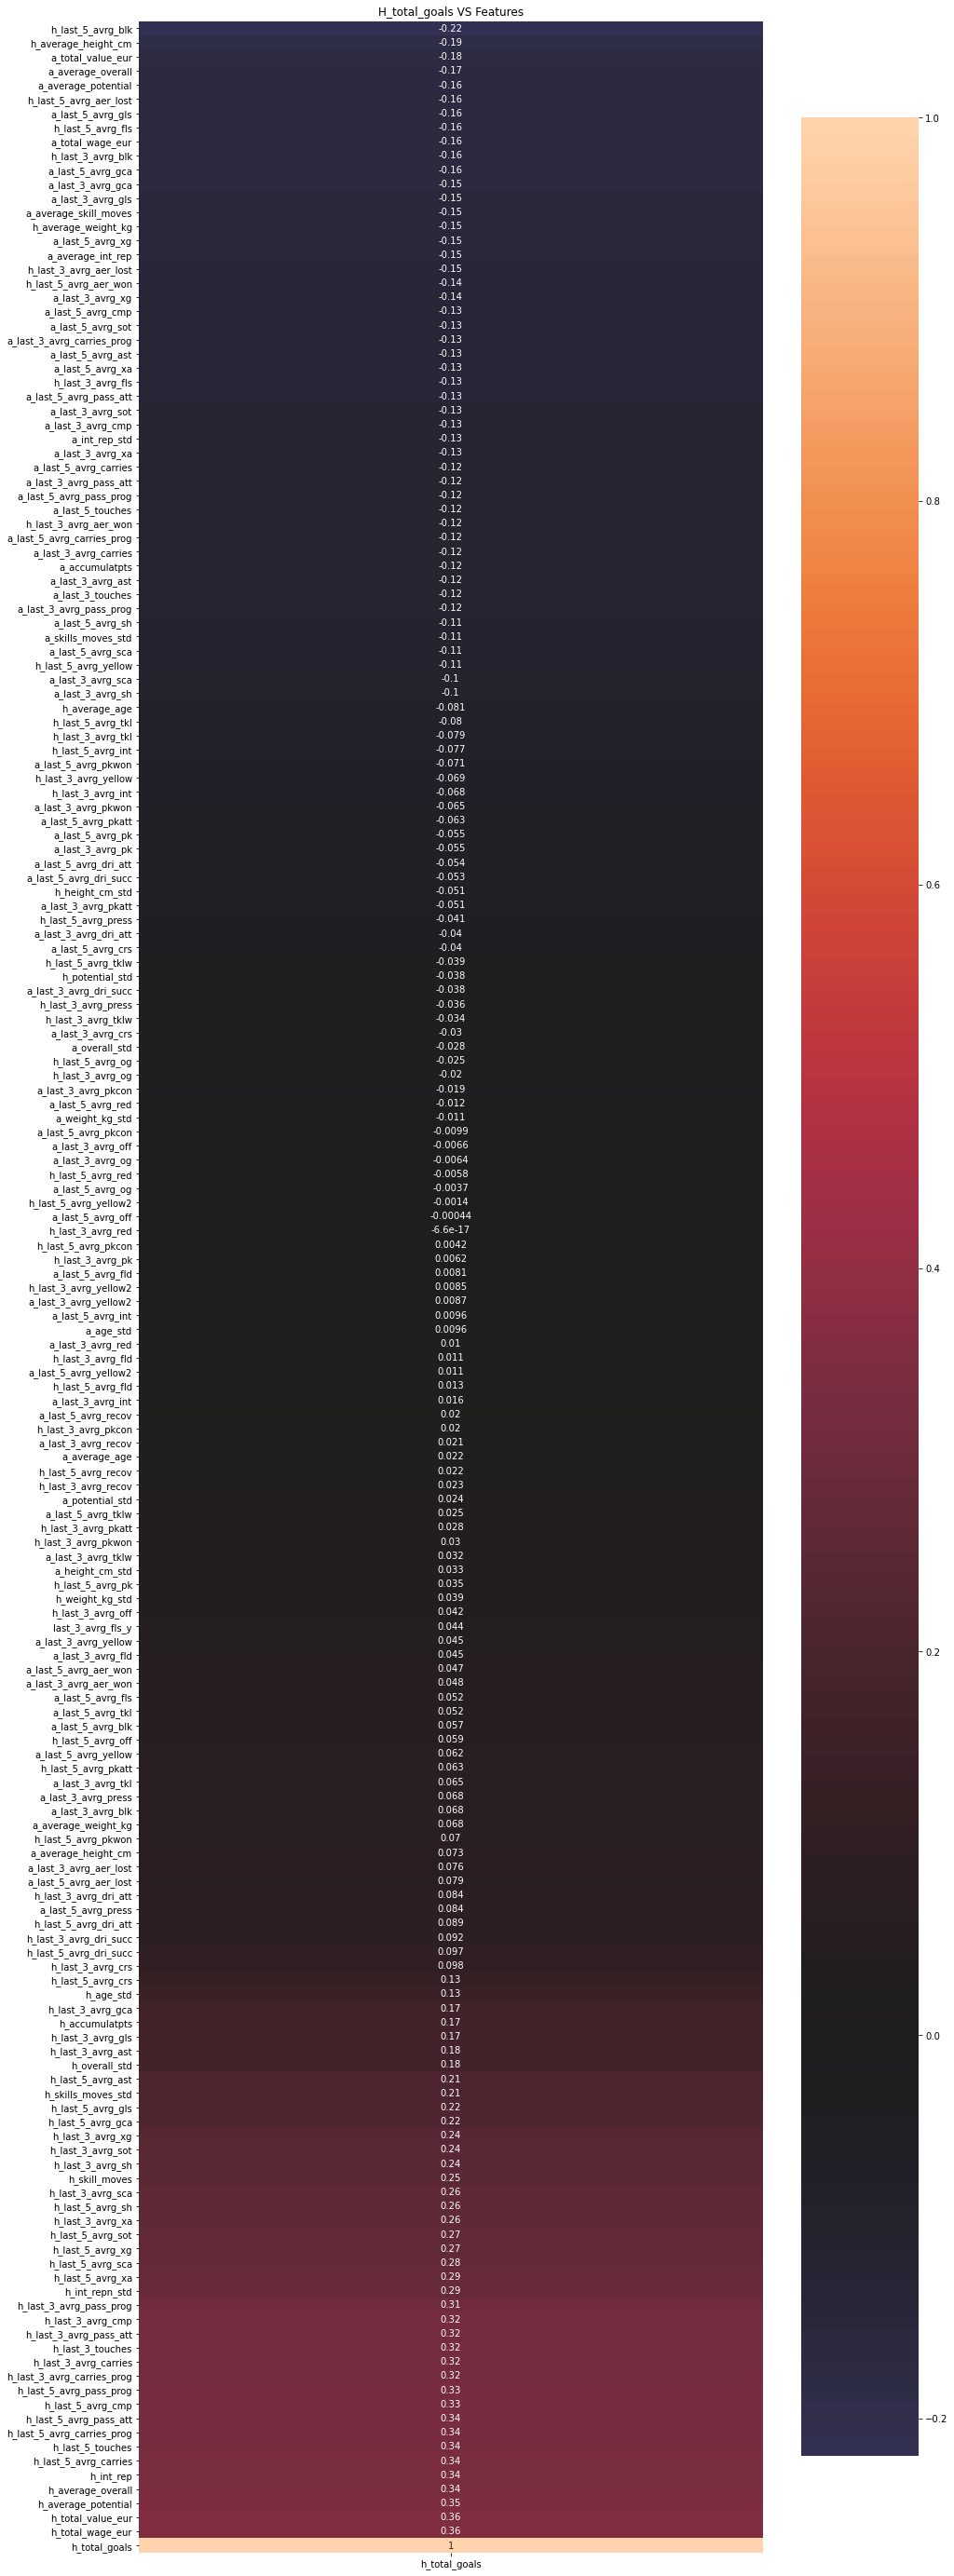

In [15]:
plt.figure(figsize=(15,50))
sns.heatmap(train_1.corr()[['h_total_goals']].sort_values('h_total_goals'), annot=True,center =0)
plt.title('H_total_goals VS Features')

Looking at the heatmap, some home features are very negatively correlated. Features such as past matches blocks, home team average height. Other features includes away team value and away average overall.

Positively correlated features are mostly home team stats, such as team total wages and values, team average potential and value. The only past matches feature is average carries for last 5 matches.

We will remove features which are correlated between 0.24 to -0.15. This is due to that there are lesser features that are negatively correlated and we will try to make the features balanced

In [16]:
#Trying to find the balance
train_corrs = train_1.corrwith(train['h_total_goals'])
train_corrs_index = train_corrs[(train_corrs < 0.24) & (train_corrs > -0.15)].index
list(train_corrs_index)

['h_last_5_avrg_gls',
 'h_last_5_avrg_ast',
 'h_last_5_avrg_pk',
 'h_last_5_avrg_pkatt',
 'h_last_5_avrg_yellow',
 'h_last_5_avrg_red',
 'h_last_5_avrg_press',
 'h_last_5_avrg_tkl',
 'h_last_5_avrg_int',
 'h_last_5_avrg_gca',
 'h_last_5_avrg_dri_succ',
 'h_last_5_avrg_dri_att',
 'h_last_5_avrg_yellow2',
 'h_last_5_avrg_fld',
 'h_last_5_avrg_off',
 'h_last_5_avrg_crs',
 'h_last_5_avrg_tklw',
 'h_last_5_avrg_pkwon',
 'h_last_5_avrg_pkcon',
 'h_last_5_avrg_og',
 'h_last_5_avrg_recov',
 'h_last_5_avrg_aer_won',
 'h_last_3_avrg_gls',
 'h_last_3_avrg_ast',
 'h_last_3_avrg_pk',
 'h_last_3_avrg_pkatt',
 'h_last_3_avrg_yellow',
 'h_last_3_avrg_red',
 'h_last_3_avrg_press',
 'h_last_3_avrg_tkl',
 'h_last_3_avrg_int',
 'h_last_3_avrg_gca',
 'h_last_3_avrg_dri_succ',
 'h_last_3_avrg_dri_att',
 'h_last_3_avrg_yellow2',
 'h_last_3_avrg_fls',
 'h_last_3_avrg_fld',
 'h_last_3_avrg_off',
 'h_last_3_avrg_crs',
 'h_last_3_avrg_tklw',
 'h_last_3_avrg_pkwon',
 'h_last_3_avrg_pkcon',
 'h_last_3_avrg_og',
 '

In [17]:
#Dropping columns that are not so correlaed
train_h = train_1.drop(columns = train_corrs_index)

Text(0.5, 1.0, 'Home Total Goals VS Features')

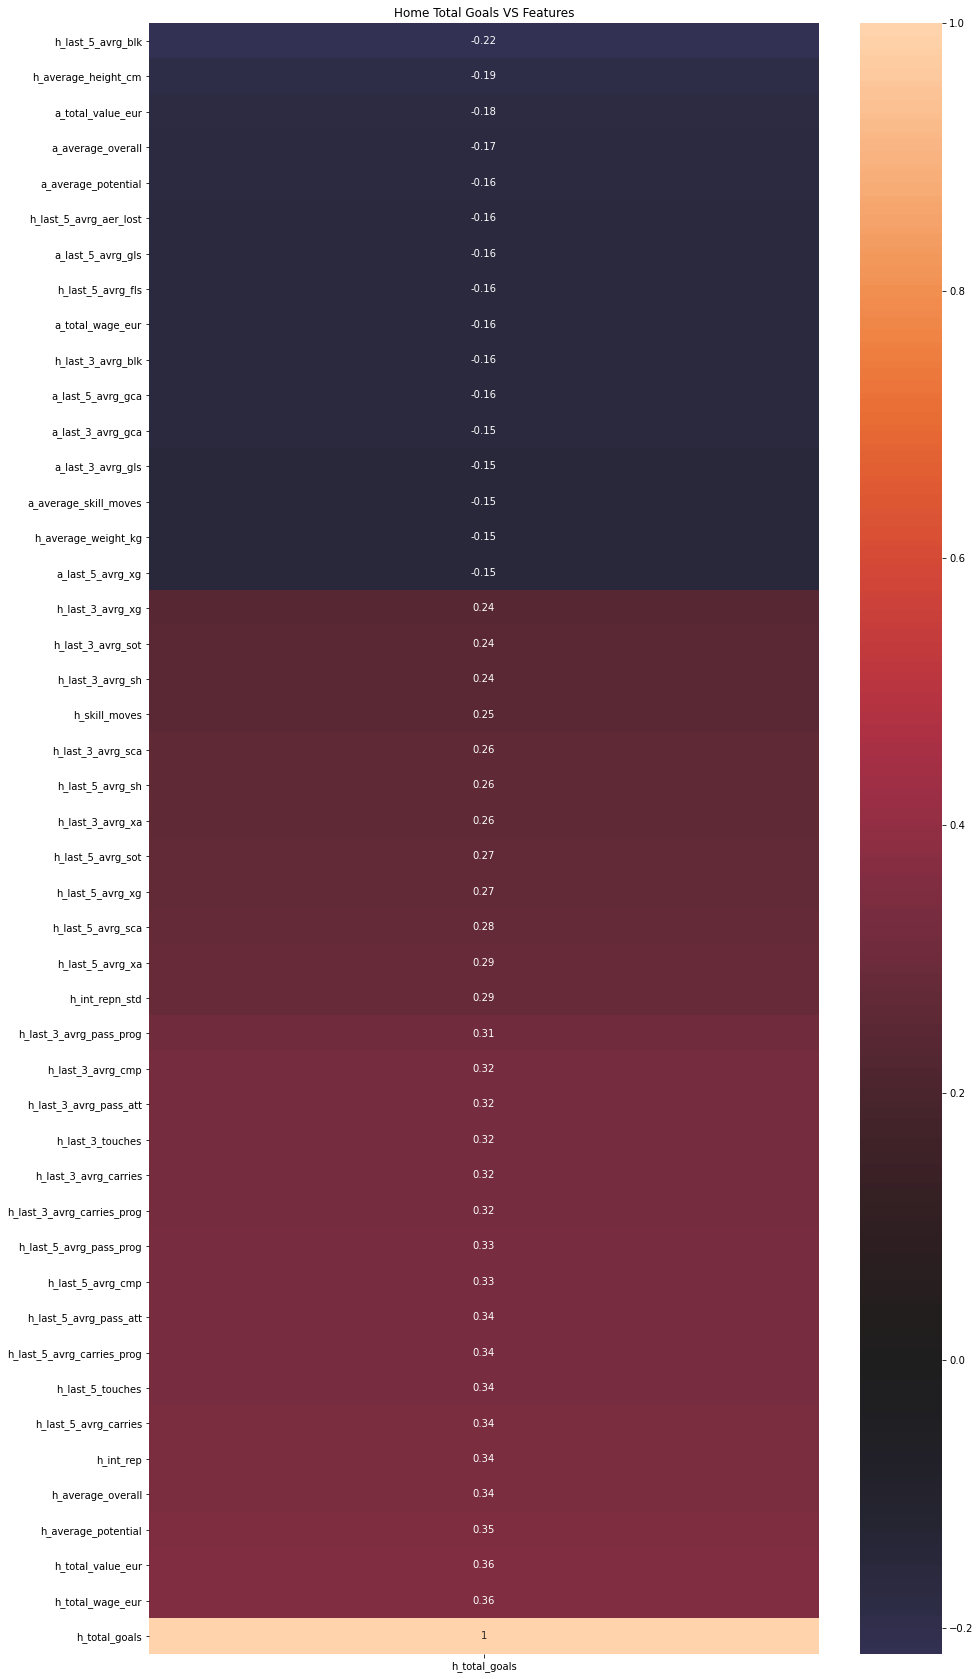

In [18]:
#Restudying the heatmap of the correlation between away total goals and remaining features
#Correlation between result and other features
plt.figure(figsize=(15,30))
sns.heatmap(train_h.corr()[['h_total_goals']].sort_values('h_total_goals'), annot=True,center =0)
plt.title('Home Total Goals VS Features')

Most of the remaining features belong to the home team, and the most positive correlated ones are the team stats.

In [80]:
#Shape of the final data
train_h.shape

(1302, 51)

In [81]:
train_h.columns

Index(['date', 'match', 'home', 'stadium', 'h_last_5_avrg_sh',
       'h_last_5_avrg_sot', 'h_last_5_touches', 'h_last_5_avrg_blk',
       'h_last_5_avrg_xg', 'h_last_5_avrg_xa', 'h_last_5_avrg_sca',
       'h_last_5_avrg_cmp', 'h_last_5_avrg_pass_att',
       'h_last_5_avrg_pass_prog', 'h_last_5_avrg_carries',
       'h_last_5_avrg_carries_prog', 'h_last_5_avrg_fls',
       'h_last_5_avrg_aer_lost', 'h_last_3_avrg_sh', 'h_last_3_avrg_sot',
       'h_last_3_touches', 'h_last_3_avrg_blk', 'h_last_3_avrg_xg',
       'h_last_3_avrg_xa', 'h_last_3_avrg_sca', 'h_last_3_avrg_cmp',
       'h_last_3_avrg_pass_att', 'h_last_3_avrg_pass_prog',
       'h_last_3_avrg_carries', 'h_last_3_avrg_carries_prog', 'away',
       'a_last_5_avrg_gls', 'a_last_5_avrg_xg', 'a_last_5_avrg_gca',
       'a_last_3_avrg_gls', 'a_last_3_avrg_gca', 'h_total_goals',
       'h_total_value_eur', 'h_total_wage_eur', 'h_average_height_cm',
       'h_average_weight_kg', 'h_average_overall', 'h_average_potential',
       '

## Building the Model

### Train Test Split for Home Total Goals

We will be splitting the data into train and test set. After that, we will smote the train set as the dataset is very imbalanced. 

In [20]:
train_h.head()

,date,match,home,stadium,h_last_5_avrg_sh,h_last_5_avrg_sot,h_last_5_touches,h_last_5_avrg_blk,h_last_5_avrg_xg,h_last_5_avrg_xa,h_last_5_avrg_sca,h_last_5_avrg_cmp,h_last_5_avrg_pass_att,h_last_5_avrg_pass_prog,h_last_5_avrg_carries,h_last_5_avrg_carries_prog,h_last_5_avrg_fls,h_last_5_avrg_aer_lost,h_last_3_avrg_sh,h_last_3_avrg_sot,h_last_3_touches,h_last_3_avrg_blk,h_last_3_avrg_xg,h_last_3_avrg_xa,h_last_3_avrg_sca,h_last_3_avrg_cmp,h_last_3_avrg_pass_att,h_last_3_avrg_pass_prog,h_last_3_avrg_carries,h_last_3_avrg_carries_prog,away,a_last_5_avrg_gls,a_last_5_avrg_xg,a_last_5_avrg_gca,a_last_3_avrg_gls,a_last_3_avrg_gca,h_total_goals,h_total_value_eur,h_total_wage_eur,h_average_height_cm,h_average_weight_kg,h_average_overall,h_average_potential,h_int_rep,h_skill_moves,h_int_repn_std,a_total_value_eur,a_total_wage_eur,a_average_overall,a_average_potential,a_average_skill_moves
10,2017-08-19,Southampton_vs_West_Ham_United,Southampton,"St. Mary's Stadium, Southampton",30.0,3.0,645.0,10.0,2.0,1.5,47.0,437.0,549.0,41.0,439.0,60.0,11.0,8.0,30.0,3.0,645.0,10.0,2.0,1.5,47.0,437.0,549.0,41.0,439.0,60.0,West Ham United,0.0,0.6,0.0,0.0,0.0,3,192000000,1330000,182.28,76.78,77.17,80.44,1.78,2.61,0.43,204200000,1646000,77.11,79.89,2.53
11,2017-08-19,Swansea_City_vs_Manchester_United,Swansea City,"Liberty Stadium, Swansea, Glamorgan",4.0,0.0,490.0,28.0,0.4,0.3,7.0,292.0,383.0,21.0,304.0,17.0,15.0,11.0,4.0,0.0,490.0,28.0,0.4,0.3,7.0,292.0,383.0,21.0,304.0,17.0,Manchester United,4.0,2.0,7.0,4.0,7.0,0,129600000,970000,182.29,78.59,75.53,78.41,1.76,2.88,0.56,491900000,2420000,82.29,84.88,2.94
12,2017-08-19,Stoke_City_vs_Arsenal,Stoke City,"Bet365 Stadium, Stoke-on-Trent",10.0,1.0,478.0,16.0,0.1,0.1,15.0,229.0,361.0,33.0,269.0,36.0,12.0,9.0,10.0,1.0,478.0,16.0,0.1,0.1,15.0,229.0,361.0,33.0,269.0,36.0,Arsenal,4.0,2.2,7.0,4.0,7.0,1,173000000,1010000,185.06,80.44,77.31,80.19,2.00,2.69,0.37,434500000,2245000,81.11,83.94,2.78
13,2017-08-19,Burnley_vs_West_Bromwich_Albion,Burnley,"Turf Moor, Burnley",10.0,5.0,447.0,20.0,0.8,0.6,16.0,248.0,344.0,23.0,235.0,23.0,14.0,8.0,10.0,5.0,447.0,20.0,0.8,0.6,16.0,248.0,344.0,23.0,235.0,23.0,West Bromwich Albion,1.0,1.1,2.0,1.0,2.0,0,103475000,810000,182.65,77.12,74.29,76.06,1.18,2.29,0.39,128550000,1060000,75.50,77.67,2.50
14,2017-08-19,Bournemouth_vs_Watford,Bournemouth,"Vitality Stadium, Bournemouth",9.0,2.0,739.0,13.0,0.4,0.3,14.0,530.0,642.0,41.0,589.0,55.0,3.0,9.0,9.0,2.0,739.0,13.0,0.4,0.3,14.0,530.0,642.0,41.0,589.0,55.0,Watford,3.0,1.9,3.0,3.0,3.0,0,115200000,970000,180.06,75.44,74.56,78.33,1.17,2.78,0.51,142700000,870000,76.65,78.94,2.65


In [21]:
train_h_2 = train_h.drop(columns = ['h_total_goals'])

In [23]:
X = train_h[train_h_2.columns]
y = train_h['h_total_goals']

In [24]:
X.shape

(1302, 50)

In [25]:
#We will split the data accordingly to order as it is date time sensitive
X_train_full, X_test_full, y_train, y_test = train_test_split(X, y, random_state=42,shuffle=False)

In [26]:
X_train = X_train_full.drop(columns = ['date','match','home','away','stadium'])
X_test = X_test_full.drop(columns = ['date','match','home','away','stadium'])

In [27]:
#As the ranges of the features are differnet, lets normalize
mm = MinMaxScaler()
Xmm_train = mm.fit_transform(X_train)
Xmm_test = mm.transform(X_test)

In [28]:
y_train.value_counts(normalize=True)

1    0.332992
2    0.257172
0    0.222336
3    0.108607
4    0.050205
5    0.025615
6    0.003074
Name: h_total_goals, dtype: float64

In [29]:
#Smote-ing to balance the data
sm = SMOTE(random_state=42,k_neighbors=1)

Xsm_train, ysm_train = sm.fit_sample(Xmm_train, y_train)

In [30]:
ysm_train.value_counts(normalize=True)

0    0.142857
2    0.142857
4    0.142857
6    0.142857
1    0.142857
3    0.142857
5    0.142857
Name: h_total_goals, dtype: float64

### Logistic Regression

In this section, we will use Logistic Regression.

In [31]:
#Gridsearch to look for best params
lr = LogisticRegression(random_state=42)
lr_params = {
    'C': np.linspace(0.1,1,5)
}
#Gridsearch and fit the model
gs_lr = GridSearchCV(lr, param_grid = lr_params, cv=5,n_jobs=-1, verbose=1,scoring='f1_micro')
gs_lr.fit(Xsm_train, ysm_train)

#Getting the best params
gs_lr.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    2.6s finished


LogisticRegression(random_state=42)

In [32]:
lr = LogisticRegression(random_state=42)

In [33]:
lr.fit(Xsm_train, ysm_train)

LogisticRegression(random_state=42)

#### Evaluation of Logistic Regression Model

In [35]:
print(lr.score(Xsm_train, ysm_train))
print(lr.score(Xmm_test,y_test))

0.5072527472527473
0.254601226993865


In [36]:
lr_coeff = np.exp(lr.coef_[0])
imp_lr = pd.DataFrame(lr_coeff, X_train.columns, columns=['coef']).sort_values(by='coef',ascending=False)
imp_lr.head(53)

,coef
a_total_value_eur,5.336588
a_last_3_avrg_gca,4.764687
a_last_5_avrg_xg,2.431878
h_average_weight_kg,2.051455
h_average_height_cm,1.988452
h_last_5_avrg_blk,1.975032
a_last_3_avrg_gls,1.905481
h_last_5_avrg_fls,1.747808
h_last_3_avrg_sot,1.673863
h_last_3_avrg_cmp,1.649264


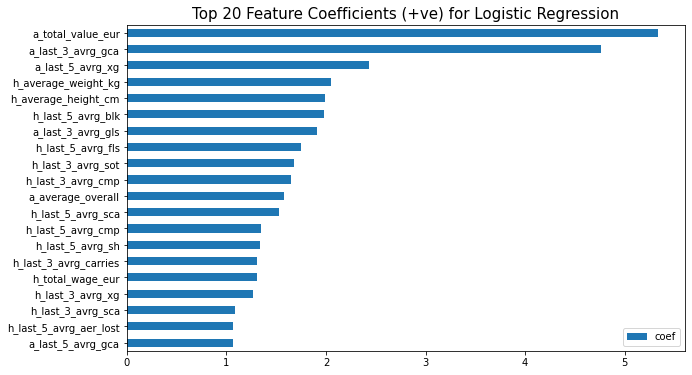

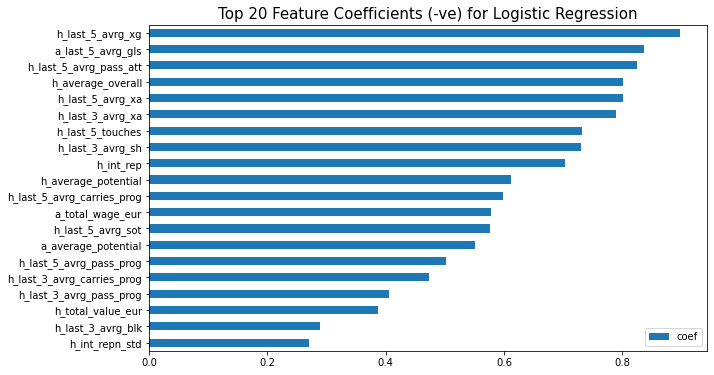

In [37]:
# Plotting top 20 +ve features in bar chart
imp_lr.head(20).plot(kind='barh', figsize=(10,6))
plt.title('Top 20 Feature Coefficients (+ve) for Logistic Regression', fontsize=15)
plt.gca().invert_yaxis()
plt.legend(loc=4);

imp_lr.tail(20).plot(kind='barh', figsize=(10,6))
plt.title('Top 20 Feature Coefficients (-ve) for Logistic Regression', fontsize=15)
plt.gca().invert_yaxis()
plt.legend(loc=4);

There is a large overfitting of the data based on the train and test score. 

For the top 20 positive feature coefficients, there are a mixture of past matches and team statistics. Similar, the top 20 negative feature coefficients have a mixture of past matches and team statistics. However, mostly are home related stats. It is a bit of different as better performance of the home team should have a higher chance of scoring a goal.

In [38]:
# Initialize empty list to store all the scores and corresponding model names
model_name = []
model_scores = []
model_var = []
model_test_scores = []

#Adding into list for evaluation
model_name.append('Logistic Regression')
model_scores.append(lr.score(Xsm_train, ysm_train))
model_var.append(lr)
model_test_scores.append(lr.score(Xmm_test,y_test))

### Random Forest Classification

Here we will be using the Random Forest Classification.

In [39]:
rf = RandomForestClassifier(random_state=42)
#Include params to test
rf_params = {
    'n_estimators': [80, 100, 120],
    'max_depth': [3, 5],
    'min_samples_leaf': [2, 4],
    'min_samples_split' : [2, 4]
}
#Grid-Searching
gs_rf = GridSearchCV(rf, param_grid = rf_params, cv=5,n_jobs=-1,verbose=1,scoring='f1_micro')
#Fitting the model and getting the best estimator
gs_rf.fit(Xsm_train, ysm_train)
gs_rf.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    4.0s finished


RandomForestClassifier(max_depth=5, min_samples_leaf=2, n_estimators=120,
                       random_state=42)

In [40]:
rf = RandomForestClassifier(max_depth=5, min_samples_leaf=2, n_estimators=120,
                       random_state=42)

In [41]:
rf.fit(Xsm_train, ysm_train)

RandomForestClassifier(max_depth=5, min_samples_leaf=2, n_estimators=120,
                       random_state=42)

#### Evaluation of Random Forest Model

In [42]:
print(rf.score(Xsm_train, ysm_train))
print(rf.score(Xmm_test,y_test))

0.6395604395604395
0.2791411042944785


In [43]:
#Random Forest Features ranked by importanc
rf_impt_feature = rf.feature_importances_
rf_impt_df = pd.DataFrame(index = X_test.columns, data = rf_impt_feature, columns = ['Importance']).sort_values('Importance',ascending=False)
rf_impt_df.head()

,Importance
h_average_weight_kg,0.091019
h_average_height_cm,0.066033
h_average_potential,0.065338
h_total_value_eur,0.054026
h_average_overall,0.052873


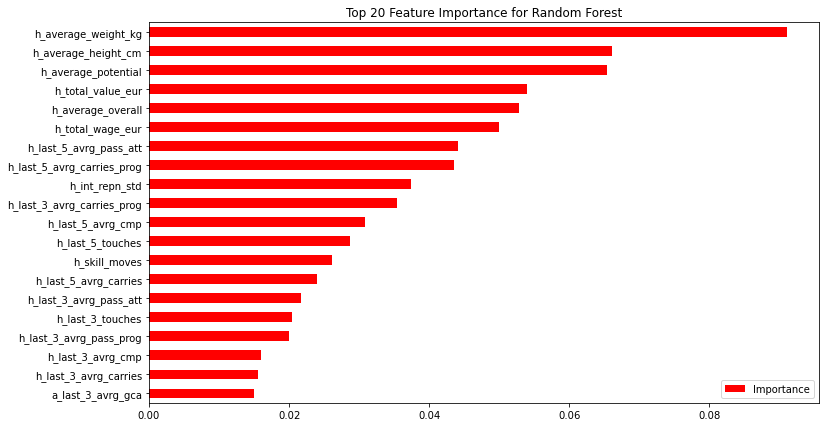

In [44]:
rf_impt_df.head(20).plot(kind='barh',figsize=(12,7),color='red',label=rf_impt_df.columns[:20])
plt.title('Top 20 Feature Importance for Random Forest')
plt.gca().invert_yaxis()
plt.legend(loc=4);

The top 5 important features for Random Forest are the home total value, average potential, total wage, average height and international reputation. It seems that team statistics are more important in this model. I think the decision outcomes get influenced by how good or how strong the home team is. 

The training score and test score are very wide apart. There is alot of overfitting in the data.

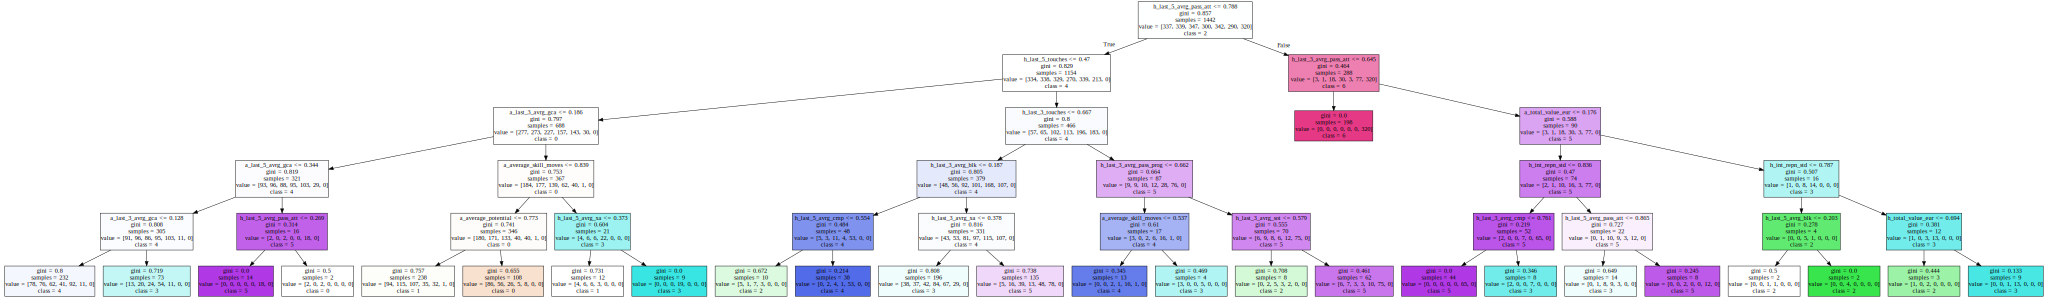

In [45]:
# DOT data
dotfile = open("images/tree_home_goals.dot", 'w')
dot_data = export_graphviz(rf.estimators_[10], out_file=None, 
                               feature_names= X_train.columns,  
                               class_names=['0','1','2','3','4','5','6'],
                                filled=True)

#Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

Despite the importance being mostly team stats, the random forest trees use a lot of past matches stats.

In [46]:
#Adding into list for evaluation
model_name.append('Random Forest')
model_scores.append(rf.score(Xsm_train, ysm_train))
model_var.append(rf)
model_test_scores.append(rf.score(Xmm_test,y_test))

### ExtraTrees Classifier

Here we will be exploring the usage of ExtraTrees Classifier.

In [47]:
et = ExtraTreesClassifier(random_state=42)
# Including hyperparameters
et_params = {
    'n_estimators': [80, 100, 120],
    'max_depth': [3, 5],
    'min_samples_leaf': [2, 4],
    'min_samples_split' : [2, 4],
}
#Grid-Searching
gs_et = GridSearchCV(et, param_grid = et_params, cv=5,n_jobs=-1,verbose=1,scoring='f1_micro')
gs_et.fit(Xsm_train, ysm_train)
#Getting the best estimator
gs_et.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.9s finished


ExtraTreesClassifier(max_depth=5, min_samples_leaf=2, n_estimators=120,
                     random_state=42)

In [48]:
#Using the best parameters and fit the model
et = ExtraTreesClassifier(max_depth=5, min_samples_leaf=2,n_estimators=120,random_state=42)
et.fit(Xsm_train, ysm_train)

ExtraTreesClassifier(max_depth=5, min_samples_leaf=2, n_estimators=120,
                     random_state=42)

#### Evaluation of ExtraTrees Classifier

In [49]:
print(et.score(Xsm_train,ysm_train))
print(et.score(Xmm_test,y_test))

0.5995604395604396
0.24539877300613497


In [50]:
et_impt_feature = et.feature_importances_
et_impt_df = pd.DataFrame(index = X_test.columns, data = et_impt_feature, columns = ['Importance']).sort_values('Importance',ascending=False)
et_impt_df.head()


,Importance
h_total_value_eur,0.084277
h_average_weight_kg,0.056153
h_average_potential,0.056085
h_average_height_cm,0.055608
h_total_wage_eur,0.049154


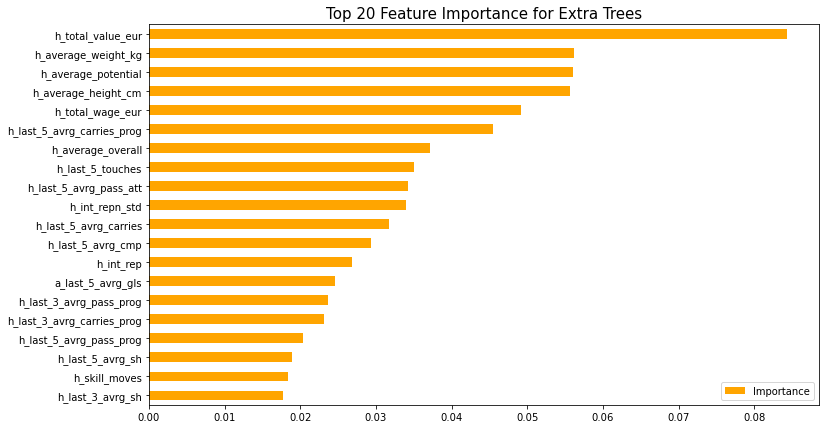

In [51]:
# Top 20 features plot
et_impt_df.head(20).plot(kind='barh', label=et_impt_df.columns, figsize=(12,7), color='orange')
plt.title('Top 20 Feature Importance for Extra Trees', fontsize=15)
plt.gca().invert_yaxis()
plt.legend(loc=4);

There is an overfit. The train and test score are quite wide apart. 

The top 20 important features for Extra Tree model are similar to Random Forest model. Mostly are team statistics except for home last 5 average carries progressive being the only past match stats. 

Most of the top 20 feature importances for extra tree are related to the home team. I assume that it is influenced by how strong the home team is.

In [52]:
#Adding into list for evaluation
model_name.append('Extra Trees')
model_scores.append(et.score(Xsm_train, ysm_train))
model_var.append(et)
model_test_scores.append(et.score(Xmm_test,y_test))

### AdaBoost Classifier

In this section, we will explore the usage of AdaBoost Classifier.

In [78]:
# ada =  AdaBoostClassifier(random_state=42)

# Hyperparameters
ada_params = {
    'n_estimators': [20, 30, 40, 50],
    'learning_rate': [0.8, 0.9, 1]
}

gs_ada = GridSearchCV(ada, param_grid = ada_params, cv=5, n_jobs=-1,verbose=1,scoring='f1_micro')
gs_ada.fit(Xsm_train, ysm_train)
gs_ada.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    4.1s finished


AdaBoostClassifier(learning_rate=0.9, n_estimators=30, random_state=42)

In [54]:
ada = AdaBoostClassifier(learning_rate=0.9, n_estimators=30, random_state=42)
ada.fit(Xsm_train, ysm_train)

AdaBoostClassifier(learning_rate=0.9, n_estimators=30, random_state=42)

#### Evaluation of AdaBoost Classifier

In [55]:
print(ada.score(Xsm_train, ysm_train))
print(ada.score(Xmm_test,y_test))

0.46505494505494505
0.3006134969325153


In [56]:
#Ada Feature Importance
ada_impt_feature = ada.feature_importances_
ada_impt_df = pd.DataFrame(index = X_test.columns, data = ada_impt_feature, columns = ['Importance']).sort_values('Importance',ascending=False)
ada_impt_df.head()

,Importance
h_average_potential,0.300000
h_average_weight_kg,0.233333
h_last_5_avrg_aer_lost,0.033333
a_last_5_avrg_gca,0.033333
a_last_3_avrg_gca,0.033333


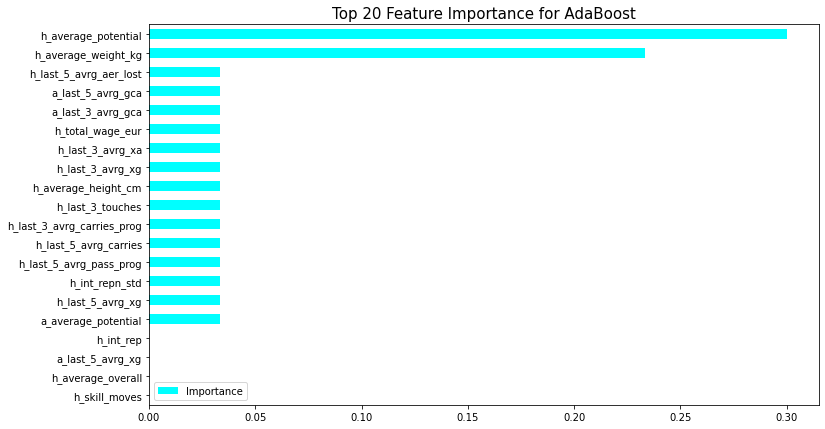

In [57]:
ada_impt_df.head(20).plot(kind='barh', label=ada_impt_df.columns[:20], figsize=(12,7), color='cyan')
plt.title('Top 20 Feature Importance for AdaBoost', fontsize=15)
plt.gca().invert_yaxis()

The train and test score are closer compared to the other models above.

There are a mixture of past matches stats and team stats for the top important features. However, the most important is home average potential which is a team stat. So far, most of the models are very influenced by the home team average potential. 



In [58]:
#Adding into list for evaluation
model_name.append('AdaBoost')
model_scores.append(ada.score(Xsm_train, ysm_train))
model_var.append(ada)
model_test_scores.append(ada.score(Xmm_test,y_test))

### Gradient Boost Classifier

We will explore the usage of Gradient Boost Classifier in this section.

In [59]:
gboost = GradientBoostingClassifier(random_state=42)
#Setting the params
gboost_params = {
    'n_estimators': [80, 100, 120, 150],
    'max_depth': [1, 2, 3],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2]}
    
#Grid searching    
gs_gboost = GridSearchCV(gboost, param_grid = gboost_params, cv=5,n_jobs=-1,verbose=1,scoring='f1_micro')
#Fit the model
gs_gboost.fit(Xsm_train, ysm_train)
#Getting the best params
gs_gboost.best_estimator_

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  3.4min finished


GradientBoostingClassifier(n_estimators=150, random_state=42)

In [60]:
gboost = GradientBoostingClassifier(n_estimators=150,random_state=42)
gboost.fit(Xsm_train, ysm_train)

GradientBoostingClassifier(n_estimators=150, random_state=42)

#### Evaluation of Gradient Boost Classifier

In [62]:
print(gboost.score(Xsm_train,ysm_train))
print(gboost.score(Xmm_test,y_test))

0.9876923076923076
0.3128834355828221


In [63]:
imp_gboost = pd.DataFrame(gboost.feature_importances_,index=X_test.columns,columns=['importance']).sort_values(by='importance', ascending=False)
imp_gboost.head()

,importance
h_average_potential,0.126613
h_average_weight_kg,0.083454
h_last_3_avrg_pass_prog,0.047235
h_last_5_avrg_blk,0.032721
h_skill_moves,0.029828


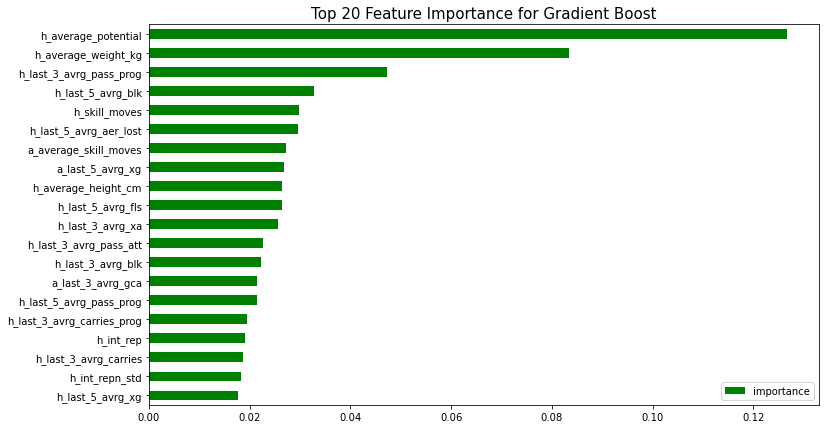

In [64]:
# Plot in bar chart
imp_gboost.head(20).plot(kind='barh', label=imp_gboost.columns[:20], figsize=(12,7), color='green')
plt.title('Top 20 Feature Importance for Gradient Boost', fontsize=15)
plt.gca().invert_yaxis()
plt.legend(loc=4);

Based on the scoring, there is a large overfit. The train score is almost 1, but the test score is slightly lower than baseline score.

Similar, the top most important feature here is home team average potential. This model has more past match performances which is more important.

In [65]:
#Adding into list for evaluation
model_name.append('GradientBoosting')
model_scores.append(gboost.score(Xsm_train, ysm_train))
model_var.append(gboost)
model_test_scores.append(gboost.score(Xmm_test, y_test))

### Support Vector Classifier

In this section, we will try to build our model using support vector classifier.

In [66]:
svc = SVC(random_state=42)

# Setting Params
svc_params = {
    'C': [1, 0.1],
    'kernel': ['rbf', 'poly'],
    'degree': [2, 3]
}

gs_svc = GridSearchCV(svc, param_grid = svc_params, cv=5,n_jobs=-1, verbose=1,scoring='f1_micro')

gs_svc.fit(Xsm_train, ysm_train)
#Getting the best params
gs_svc.best_estimator_

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.8s finished


SVC(C=1, kernel='poly', random_state=42)

In [67]:
svc = SVC(C=1, kernel='poly', random_state=42)
svc.fit(Xsm_train, ysm_train)

SVC(C=1, kernel='poly', random_state=42)

In [69]:
#There is an overfit on the data
print(svc.score(Xmm_train,y_train))
print(svc.score(Xmm_test,y_test))

0.625
0.2852760736196319


There is still an overfit. The baseline score is higher than the test score.

In [70]:
#Adding into list for evaluation
model_name.append('Support Vector Classifier')
model_scores.append(svc.score(Xsm_train, ysm_train))
model_var.append(svc)
model_test_scores.append(svc.score(Xmm_test,y_test))

### Model Evaluation & Selection

In this section, we will put all the models together to evaluate and select the final model to use.

In [71]:
model_var

[LogisticRegression(random_state=42),
 RandomForestClassifier(max_depth=5, min_samples_leaf=2, n_estimators=120,
                        random_state=42),
 ExtraTreesClassifier(max_depth=5, min_samples_leaf=2, n_estimators=120,
                      random_state=42),
 AdaBoostClassifier(learning_rate=0.9, n_estimators=30, random_state=42),
 GradientBoostingClassifier(n_estimators=150, random_state=42),
 SVC(C=1, kernel='poly', random_state=42)]

In [72]:
# View the evaluation metrics for all models in a dataframe
# Sorted by highest F1-Score
precision_list = []
recall_list = []
fscore_list = []

for model in model_var:
    y_pred = model.predict(Xmm_test)
    precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred,average = 'micro')
    precision_list.append(precision)
    recall_list.append(recall)
    fscore_list.append(fscore)

In [73]:
pd.DataFrame({'Model Type': model_name,
              'F1-Score': fscore_list,
             'Recall': recall_list,
              'Precision': precision_list,
              'Train Accuracy': model_scores,
             'Test Accuracy': model_test_scores}).sort_values(by='F1-Score',ascending=False)

,Model Type,F1-Score,Recall,Precision,Train Accuracy,Test Accuracy
4,GradientBoosting,0.312883,0.312883,0.312883,0.987692,0.312883
3,AdaBoost,0.300613,0.300613,0.300613,0.465055,0.300613
5,Support Vector Classifier,0.285276,0.285276,0.285276,0.802637,0.285276
1,Random Forest,0.279141,0.279141,0.279141,0.639560,0.279141
0,Logistic Regression,0.254601,0.254601,0.254601,0.507253,0.254601
2,Extra Trees,0.245399,0.245399,0.245399,0.599560,0.245399


In [74]:
#Plotting of confusion Matrix
def subplot_confusion_matrix(model_list, model_name, Xmm_test, y_test):
    nrows = int(np.ceil(len(model_list)/3))   # Ensure have enough rows
    fig, ax = plt.subplots(nrows=nrows, ncols=3, figsize=(14, nrows*4))   
    plt.subplots_adjust(hspace = 0.4)
    ax = ax.ravel()   # Ravel turns a matrix into a vector, which is easier to iterate
    for i, model in enumerate(model_list):   # Gives us an index value to get into all our lists
        plot_confusion_matrix(model, Xmm_test, y_test, cmap='Blues', values_format='d', ax=ax[i])
        ax[i].set_title(model_name[i])
    
        # display scale and label only on the left edge
        if i%3 != 0:
            ax[i].set_ylabel('')
            ax[i].set_yticklabels('')
    # This code below is to switch off the axes if there is an odd number of subplots
    for axes in ax.flat[len(model_list):]:
        axes.axis('off')
    fig.tight_layout()
    pass

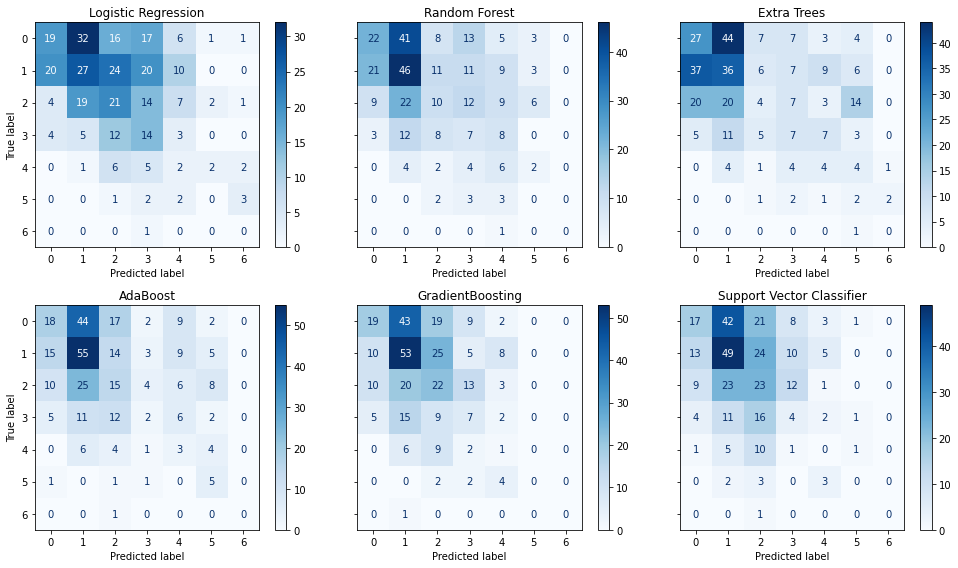

In [75]:
subplot_confusion_matrix(model_var, model_name, Xmm_test, y_test)

We will be using F1 Score micro-average as the metric in this machine learning model.It is because that we have many seven different classes and imbalance classes in our data. So based on our model building outcome, the model with the best score is Gradient Boosting.

Based on its top important features, it uses a mixture of team stats and match stats to train the model. We will be selecting Gradient boost for our production model for Home Total Goals.

[Gradient boosting](https://corporatefinanceinstitute.com/resources/knowledge/other/boosting/), just like any other ensemble machine learning procedure, sequentially adds predictors to the ensemble and follows the sequence in correcting preceding predictors to arrive at an accurate predictor at the end of the procedure. 

It utilizes the gradient descent to pinpoint the challenges in the learners’ predictions used previously. The previous error is highlighted, and, by combining one weak learner to the next learner, the error is reduced significantly over time.

Advantages:

- Often provides predictive accuracy that cannot be beat.
- Lots of flexibility - can optimize on different loss functions and provides several hyperparameter tuning options that make the function fit very flexible.
- No data pre-processing required - often works great with categorical and numerical values as is.
- Handles missing data - imputation not required.

Disdvantages:

- GBMs will continue improving to minimize all errors. This can overemphasize outliers and cause overfitting. Must use cross-validation to neutralize.
- Computationally expensive - GBMs often require many trees (>1000) which can be time and memory exhaustive.
- The high flexibility results in many parameters that interact and influence heavily the behavior of the approach (number of iterations, tree depth, regularization parameters, etc.). This requires a large grid search during tuning.
- Less interpretable although this is easily addressed with various tools (variable importance, partial dependence plots, LIME, etc.).


In [76]:
#Saving scaler as pickle
filename = 'pkl/home_goals_scaler.pkl'
pickle.dump(mm, open(filename, 'wb'))

In [77]:
#Saving model as pickle
filename = 'pkl/home_goals_production_model.pkl'
pickle.dump(gboost, open(filename, 'wb'))